<a href="https://colab.research.google.com/github/sam-umair/NLP/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow

from tensorflow.keras.preprocessing import text, sequence  # Still using Keras but through TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# from keras.preprocessing import text, sequence
# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, Dense, Dropout
# from keras.callbacks import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Reading csv files from google drive

In [ ]:
true = pd.read_csv("/content/drive/MyDrive/True.csv")
false = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [ ]:
display(true.head())
print(true.shape)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


(21417, 4)


In [ ]:
display(false.head())
print(false.shape)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


(23481, 4)


In [ ]:
true['category'] = 1
false['category'] = 0
df = pd.concat([true, false])
display(df.head())
print(df.shape)

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


(44898, 5)


In [ ]:
df['category'].unique()

array([1, 0])

In [ ]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
category,0


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    cleaned_text = " ".join(final_text)

    # Check if the cleaned text is empty
    if not cleaned_text:
        cleaned_text = "placeholder"  # Add a placeholder word

    return cleaned_text

df['clean_text'] = df['text'].apply(clean_text)

<ipython-input-10-4e27cc58dc61>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-10-4e27cc58dc61>:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
df.head()

,title,text,subject,date,category,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,WASHINGTON (Reuters) head conservative Republi...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,WASHINGTON (Reuters) Transgender people allowe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,WASHINGTON (Reuters) special counsel investiga...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,WASHINGTON (Reuters) Trump campaign adviser Ge...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,SEATTLE/WASHINGTON (Reuters) President Donald ...


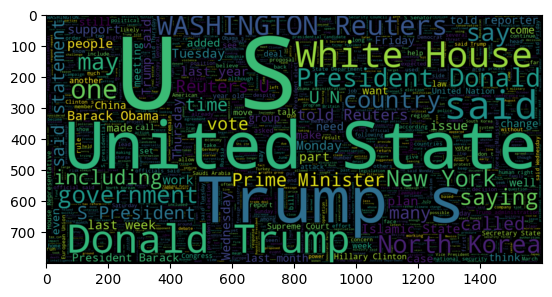

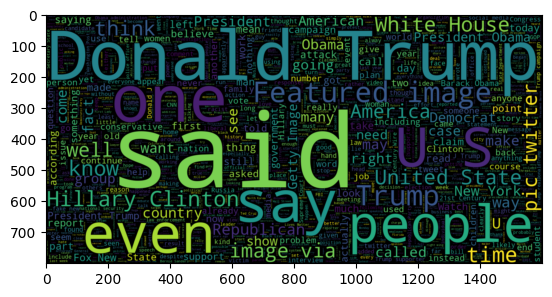

In [ ]:
# Word cloud for real and fake text
def plot_wordcloud(category):
    wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == category].clean_text))
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

# Plot word cloud for real text
plot_wordcloud(1)

# Plot word cloud for fake text
plot_wordcloud(0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.category, random_state=0)

In [ ]:
# Define the maximum number of unique words to be considered in the tokenization
max_features = 10000

# Define the maximum length of sequences (texts) after padding
maxlen = 300

# Initialize a tokenizer object that will convert text to sequences of integers
# num_words specifies the maximum number of unique words to keep based on frequency
tokenizer = text.Tokenizer(num_words=max_features)

# Fit the tokenizer on the training data. This process involves building the vocabulary based on the training texts
tokenizer.fit_on_texts(x_train)

# Convert the training texts into sequences of integers based on the tokenizer's vocabulary
# Each text is converted to a sequence of integers where each integer represents a word
tokenized_train = tokenizer.texts_to_sequences(x_train)

# Pad the sequences to ensure uniform input size for the model
# Sequences shorter than maxlen are padded with zeros at the beginning
# Sequences longer than maxlen are truncated from the beginning
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

# Convert the test texts into sequences of integers using the fitted tokenizer
# This ensures that the test texts are transformed in the same way as the training texts
tokenized_test = tokenizer.texts_to_sequences(x_test)

# Pad the test sequences to the same length as the training sequences
# This step ensures that the test data is compatible with the model input
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)


# Download Glove

In [ ]:
import requests
from tqdm import tqdm

url = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))

with open('/content/drive/MyDrive/glove.twitter.27B.zip', 'wb') as file:
    with tqdm(total=total_size, unit='B', unit_scale=True, desc='Downloading') as pbar:
        for data in response.iter_content(chunk_size=4096):
            file.write(data)
            pbar.update(len(data))


Downloading: 100%|██████████| 1.52G/1.52G [04:41<00:00, 5.39MB/s]


In [ ]:
!unzip /content/drive/MyDrive/glove.twitter.27B.zip -d /content/drive/MyDrive/glove.twitter.27B


Archive:  /content/drive/MyDrive/glove.twitter.27B.zip
  inflating: /content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.25d.txt  
  inflating: /content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.50d.txt  
  inflating: /content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.100d.txt  
  inflating: /content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.200d.txt  


In [ ]:
EMBEDDING_FILE = '/content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.100d.txt'  # Updated path

In [ ]:
import numpy as np

def get_coefs(word, *arr):
    """
    Convert a word and its associated embedding vector into a tuple,
    with the vector as a NumPy array of type 'float32'.

    Args:
    - word (str): The word.
    - arr (float): The embedding vector components.

    Returns:
    - Tuple (str, np.ndarray): The word and its embedding vector.
    """
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(embedding_file, word_index, max_features):
    """
    Load pre-trained GloVe embeddings and create an embedding matrix.
    """
    # Load embeddings from the GloVe file into a dictionary
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding='utf-8'))

    # Convert values to a list to ensure stacking works
    all_embs = np.stack(list(embeddings_index.values()))

    # Calculate the mean and standard deviation of the embedding vectors
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    # Determine the dimensionality of the embeddings
    embed_size = all_embs.shape[1]

    # Initialize the embedding matrix with random values
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

    # Populate the embedding matrix with the pre-trained embeddings
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, embed_size


# Path to the pre-trained GloVe embeddings file
EMBEDDING_FILE = '/content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.100d.txt'

# Tokenizer from preprocessing to get the word_index
tokenizer = text.Tokenizer(num_words=max_features)
x_train_raw = x_train.astype(str).tolist()  # Convert to a list of strings
tokenizer.fit_on_texts(x_train_raw)

# Load embeddings and create the embedding matrix
embedding_matrix, embed_size = load_embeddings(EMBEDDING_FILE, tokenizer.word_index, max_features)


In [ ]:
# Hyperparameters and configuration
batch_size = 256  # Number of samples per gradient update
epochs = 3        # Number of epochs to train the model
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # Metric to monitor for learning rate adjustment
    patience=2,              # Number of epochs to wait before reducing the learning rate
    verbose=1,               # Verbosity mode (1 = print messages)
    factor=0.5,              # Factor by which the learning rate is reduced
    min_lr=0.00001           # Minimum learning rate
)


# Define the Sequential model
model = Sequential()

# Add an embedding layer with pre-trained embeddings
model.add(Embedding(
    input_dim=max_features,    # Size of the vocabulary
    output_dim=embed_size,     # Dimensionality of the embedding vectors
    weights=[embedding_matrix],  # Pre-trained embeddings
    input_length=maxlen,       # Length of input sequences
    trainable=False             # Freeze the embedding layer (don't train)
))

# Add the first LSTM layer
model.add(LSTM(
    units=128,                # Number of units in the LSTM layer
    return_sequences=True,    # Return the full sequence (not just the last output)
    recurrent_dropout=0.25,   # Dropout rate for the recurrent connections
    dropout=0.25              # Dropout rate for the input connections
))

# Add the second LSTM layer
model.add(LSTM(
    units=64,                 # Number of units in the LSTM layer
    recurrent_dropout=0.1,    # Dropout rate for the recurrent connections
    dropout=0.1               # Dropout rate for the input connections
))

# Add a fully connected (dense) layer with ReLU activation
model.add(Dense(
    units=32,                 # Number of neurons in the dense layer
    activation='relu'         # Activation function
))

# Add the output layer with sigmoid activation (for binary classification)
model.add(Dense(
    units=1,                  # Single output neuron
    activation='sigmoid'      # Sigmoid activation function for binary classification
))

# Compile the model
model.compile(
    optimizer='adam',                   # Optimizer
    loss='binary_crossentropy',         # Loss function for binary classification
    metrics=['accuracy']                # Metric to evaluate model performance
)

# Train the model
history = model.fit(
    x_train,                         # Training data
    y_train,                         # Training labels
    batch_size=batch_size,           # Number of samples per batch
    validation_data=(x_test, y_test),  # Validation data and labels
    epochs=epochs,                   # Number of epochs
    callbacks=[learning_rate_reduction]  # Callbacks to adjust the learning rate
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.7605 - loss: 0.4495 - val_accuracy: 0.9592 - val_loss: 0.1237 - learning_rate: 0.0010
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 486s 4s/step - accuracy: 0.9390 - loss: 0.1666 - val_accuracy: 0.9495 - val_loss: 0.1666 - learning_rate: 0.0010
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9425 - loss: 0.1562 - val_accuracy: 0.9834 - val_loss: 0.0592 - learning_rate: 0.0010


In [ ]:
print("Accuracy on Training Data:", model.evaluate(x_train, y_train)[1] * 100, "%")
print("Accuracy on Testing Data:", model.evaluate(x_test, y_test)[1] * 100, "%")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 269s 256ms/step - accuracy: 0.9847 - loss: 0.0569
Accuracy on Training Data: 98.35773706436157 %
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 217ms/step - accuracy: 0.9826 - loss: 0.0619
Accuracy on Testing Data: 98.34298491477966 %


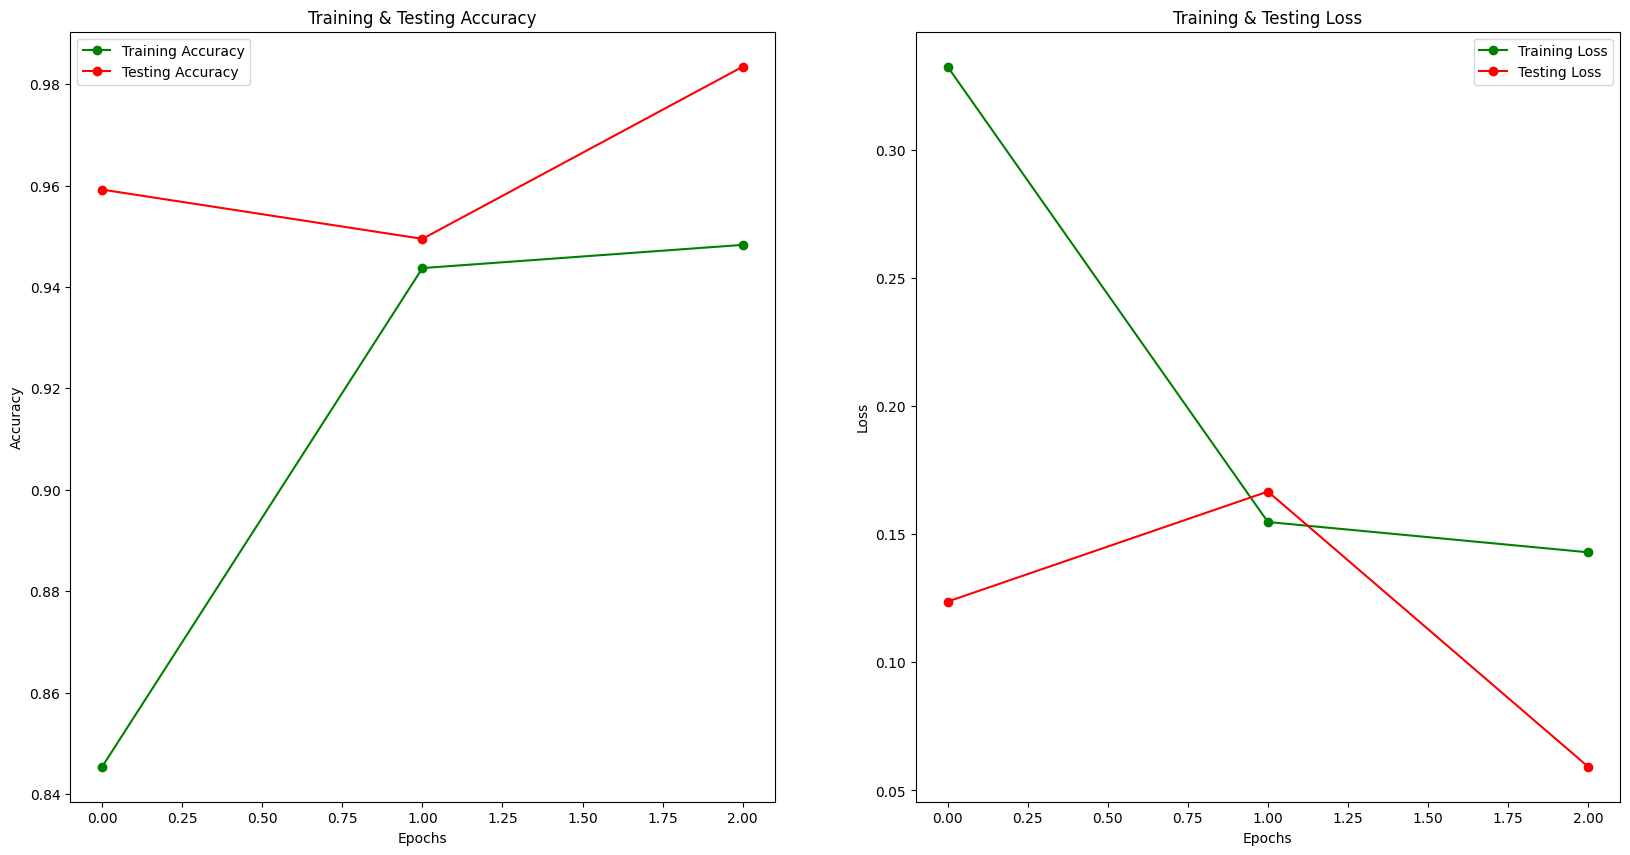

In [ ]:
# Get the actual number of epochs from the history object
actual_epochs = len(history.history['accuracy'])

epochs = [i for i in range(actual_epochs)]  # Adjust epochs array based on the actual number of epochs
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()